<font size="6"> Table of Contents</font>
<a id='destination_cell_10'></a> <br>
[Section 1](#destination_cell_1) <br><blockquote>
        1)  </blockquote>
[Section 2](#destination_cell_2)<br><blockquote>
        1) Pairplots<br>
 </blockquote>
[Section 3](#destination_cell_3)<br><blockquote>
        1) Evaluate distributions for features we will impute values for<br>
        2) Heatmap<br></blockquote>
[Section 4](#destination_cell_4)<br><blockquote>
        1) Set x and y<br>
</blockquote>


        





<font size="8">Section 1</font>
<a id='destination_cell_1'></a>

[Return to Table of Contents](#destination_cell_10)

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import mstats
from scipy import stats 
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.linear_model import ElasticNet
from scipy.stats import mstats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE

import scipy.stats as stats

In [2]:
%cd /Users/nicholassanso/Desktop/GA/projects/project-2

/Users/nicholassanso/Desktop/GA/projects/project-2


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
df= pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [5]:
df.shape

(2051, 81)

In [6]:
df_test.shape

(878, 80)

In [7]:
#you cannot combine the two dataframes to increase your sample size because the test dataframe does not have the target variable

# Find columns in df that are not in df_test
cols_in_df_not_in_test = set(df.columns) - set(df_test.columns)

# Find columns in df_test that are not in df
cols_in_test_not_in_df = set(df_test.columns) - set(df.columns)

print("Columns in df_train but not in df_test: ", cols_in_df_not_in_test)
print("Columns in df_test but not in df: ", cols_in_test_not_in_df)

Columns in df_train but not in df_test:  {'SalePrice'}
Columns in df_test but not in df:  set()


In [8]:
new_columns = [column.replace(' ', '_').replace('/', '_').lower() for column in df.columns]

df.columns = new_columns
print(new_columns)

['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'paved_drive', 'wood_deck_sf'

In [9]:
df['ms_subclass'] = df['ms_subclass'].apply(str)

<font size="8">Dropping Indexes and transforming target variable</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


In [10]:
df = df.drop(columns=['garage_cars'])

Our problem set restricted our scope to residential housing in medium and low density. This is because the features we have data on are much more likely to appear in those categories. additionally the features that would drive sale price in the other categories are different from the ones that drive RL and RM. They wouldnt belong in the same regression even if you had the data.

Direct Capitalizaiton method:
    (Net Operating Income)/(r-g)

A- Etirely different input costs from residential housing. top three input costs for farms in the United States
    1) Energy
    2) Seeds
    3) Pesticides
    
C- Far more sensitive to changes in the business cycle than residential.

I- Generally long build times keep the industrial ETFs out of sync with the business cycle altogether. Entirely different input costs

**Exclude ms_zoning variables from all the dataframes because it is a completely different regression variable <br>
Exclude garage_cars because it measures in a metric, "length of car" which is a nonstandardized and meaningless metric (we also already have garage_area which measures a something very similar)**

In [11]:
# Create a boolean mask to drop rwws
mask = df['ms_zoning'].isin(['C (all)', 'A (agr)', 'I (all)', 'RH', 'FV'])

# Use the boolean mask to drop the rows in place
df.drop(df[mask].index, inplace=True)

Ultimately we would like to predict the sales price of a house.<br> 

Embedded in some (65) of our sales price datapoints is the value of miscellanious features. misc_features is unique in the datatset as it is the only feature of a house in which we are also given its exact monetary value (and therefore contribution to the target variable, salesprice). As a result, we can get a more acurate understanding of the relationship between our predictor variables and our target variable (saleprice) if we remove the value of the miscellanious features from saleprice, as leaving its value in saleprice would serve as a counding variable. After removing the value of the miscellanious features from saleprice, we are no longer strictly predicting saleprice, but the portion of saleprice that is not attributable to the miscellanious features. <br>

Subtracting the value of the miscelanious features provides the additional benefit of not losing the predictive power of the the miscelanious variables in predicting salesprice and not having to incorporate a predictive variable in which the vast majority of its values are imputed. The histograms below underscroe this point and allow illustrate two conclusions: <br> 
1) The miscellanious features are mostly sheds of nominal value <br> 
2) Most of our observations don't have a miscellanious value <br> 
    2.a. If we included miscellanious feature as a our regression we would have to impute values for the nulls which comprise the vast majority of our obsevations. <br>

From these two conclusions, it is probably best to drop these two features altogether.

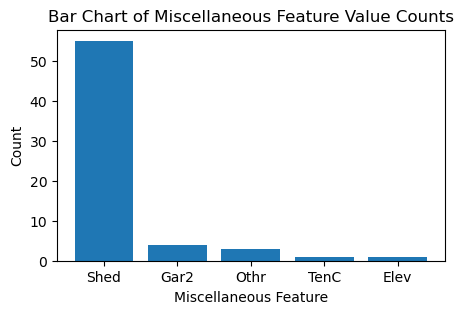

In [12]:
# Get value counts
value_counts = df['misc_feature'].value_counts()

# Create bar chart
plt.figure(figsize=(5,3))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Miscellaneous Feature')
plt.ylabel('Count')
plt.title('Bar Chart of Miscellaneous Feature Value Counts')
plt.show()


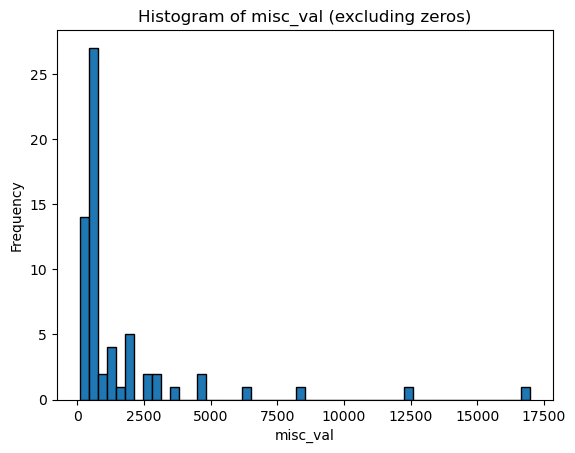

In [13]:
#Use the y-axis to gauge how few observations actually have miscellanious features and how many of the miscellanious features are of nominal value.

df_no_zeros = df[df['misc_val'] != 0]

plt.hist(df_no_zeros['misc_val'], bins=50, edgecolor='black')
plt.title('Histogram of misc_val (excluding zeros)')
plt.xlabel('misc_val')
plt.ylabel('Frequency')
plt.show()


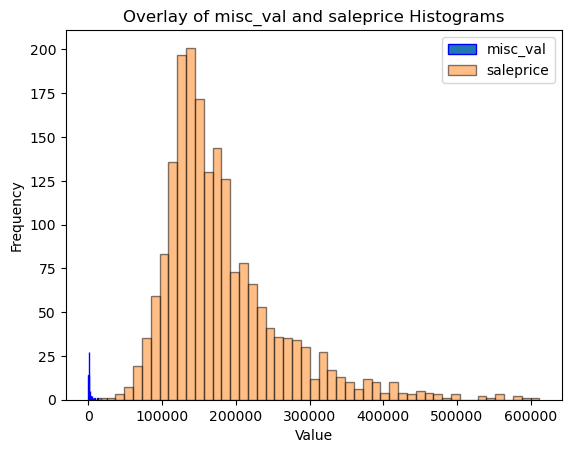

In [14]:
#plot the two histograms overlayed on one another to visually represent how immaterial misc_val is to saleprice as part of the justification for dropping the 
#feature from the regression model.

plt.hist(df_no_zeros['misc_val'], bins=50, edgecolor='blue', label='misc_val')
plt.hist(df['saleprice'], bins=50, edgecolor='black', alpha=0.5, label='saleprice')

plt.title('Overlay of misc_val and saleprice Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

**Some of the houses have high value miscelanious features like elevators. However, there is another feature, misc_value which specifically denotes the dollar amount of these features" so when training our model, we don't actually want to train it to predict saleprice, we want it to train to predict saleprice-misc_val, and then if a miscellanious item exists, to add on the value of the miscelleanious item at the end.**

In [15]:
df['saleprice-misc_val'] = df['saleprice'] - df['misc_val']

In [ ]:
#splinter df

df_size = df[['lot_frontage', 'lot_area','bsmtfin_sf_1' ,'bsmtfin_sf_2', 'bsmt_unf_sf', 
              'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'garage_area', 'wood_deck_sf',
              'open_porch_sf', 'enclosed_porch', 'pool_area', 'mas_vnr_area', 'screen_porch', '3ssn_porch']].copy()

df_quality_of_house_vars = df[['overall_qual', 'overall_cond', 'exter_qual',
                               'exter_cond','bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'bsmtfin_type_2', 
                               'kitchen_qual', 'functional', 'fireplace_qu','garage_qual', 'garage_finish', 
                               'garage_cond', 'fence', 'pool_qc']].copy()

df_age_vars = df[['year_built', 'year_remod_add', 'garage_yr_blt', 'yr_sold','mo_sold']].copy()

df_roommage_vars = df[['bsmt_full_bath','bsmt_half_bath','full_bath','half_bath',
                       'bedroom_abvgr','kitchen_abvgr', 'totrms_abvgrd','fireplaces']].copy()

df_environment_vars = df[['street','alley','neighborhood']].copy()


df_categories_of_house_vars = df[['roof_style','roof_matl','exterior_1st',
                                  'exterior_2nd','mas_vnr_type', 'foundation','bsmt_exposure','heating','heating_qc',
                                  'central_air','electrical','garage_type','paved_drive', 'ms_subclass',
                                  'bldg_type','lot_shape','land_contour','utilities', 'lot_config',
                                      'land_slope','condition_1','condition_2','house_style']].copy()

<font size="8">test for multicollinearity</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


The chart below shows the justification for PCA among the df_size dataframe

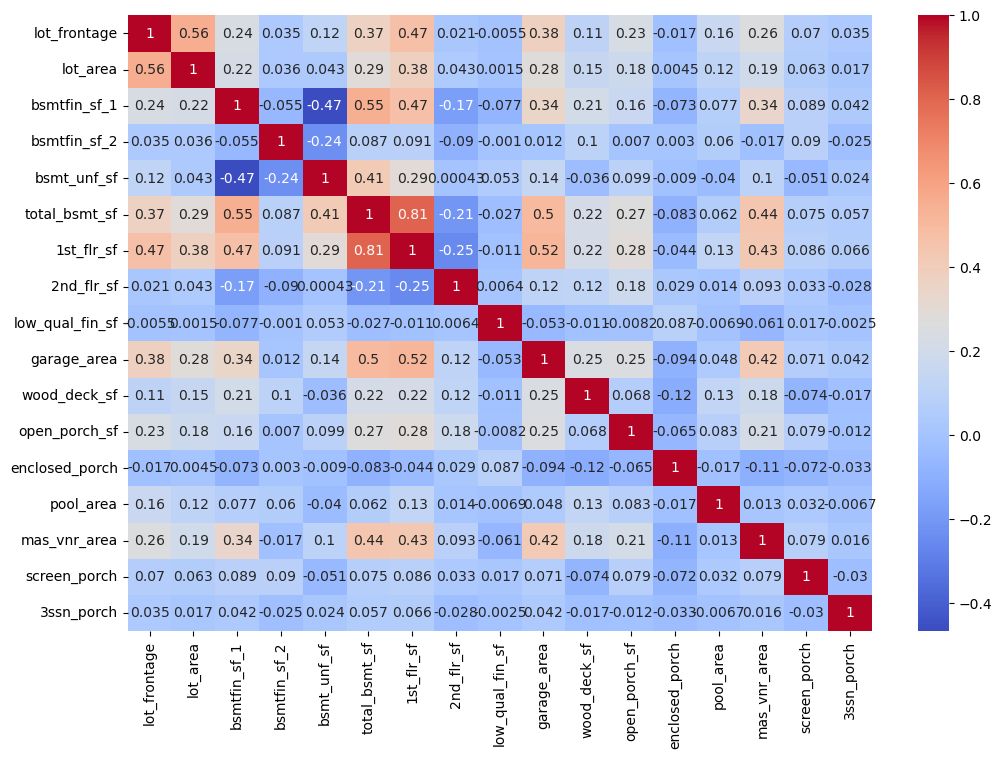

In [59]:
# Create the heatmap
plt.figure(figsize=(12,8)) # Set the figure size
sns.heatmap(df_size.corr(), annot=True, cmap='coolwarm') # Create a heatmap with correlations
plt.show()

In [84]:
# Assume `df` is your DataFrame
corr_matrix = df_size.corr()

# Get pairs of variables with correlation greater than 0.4 and less than 1
pairs_to_drop = set()
cols = df_size.columns
for i in range(0, corr_matrix.shape[1]):
    for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))

strong_pairs = []
for pair in pairs_to_drop:
    if 0.3 < corr_matrix.loc[pair[0], pair[1]] < 1:
        strong_pairs.append(pair)

print(strong_pairs)

[('1st_flr_sf', 'bsmtfin_sf_1'), ('mas_vnr_area', 'bsmtfin_sf_1'), ('lot_area', 'lot_frontage'), ('total_bsmt_sf', 'bsmt_unf_sf'), ('garage_area', 'bsmtfin_sf_1'), ('1st_flr_sf', 'total_bsmt_sf'), ('mas_vnr_area', '1st_flr_sf'), ('mas_vnr_area', 'total_bsmt_sf'), ('total_bsmt_sf', 'lot_frontage'), ('garage_area', '1st_flr_sf'), ('garage_area', 'total_bsmt_sf'), ('1st_flr_sf', 'lot_frontage'), ('1st_flr_sf', 'lot_area'), ('total_bsmt_sf', 'bsmtfin_sf_1'), ('mas_vnr_area', 'garage_area'), ('garage_area', 'lot_frontage')]


In [85]:
pairs = [('1st_flr_sf', 'bsmtfin_sf_1'), ('mas_vnr_area', 'bsmtfin_sf_1'), ('lot_area', 'lot_frontage'), ('total_bsmt_sf', 'bsmt_unf_sf'), 
         ('garage_area', 'bsmtfin_sf_1'), ('1st_flr_sf', 'total_bsmt_sf'), ('mas_vnr_area', '1st_flr_sf'), ('mas_vnr_area', 'total_bsmt_sf'), 
         ('total_bsmt_sf', 'lot_frontage'), ('garage_area', '1st_flr_sf'), ('garage_area', 'total_bsmt_sf'), ('1st_flr_sf', 'lot_frontage'), 
         ('1st_flr_sf', 'lot_area'), ('total_bsmt_sf', 'bsmtfin_sf_1'), ('mas_vnr_area', 'garage_area'), ('garage_area', 'lot_frontage')]

# Flatten the list of pairs and convert to a set to get unique values
unique_columns = set([item for sublist in pairs for item in sublist])

print(unique_columns)

{'lot_area', 'total_bsmt_sf', 'garage_area', 'bsmt_unf_sf', 'bsmtfin_sf_1', '1st_flr_sf', 'mas_vnr_area', 'lot_frontage'}


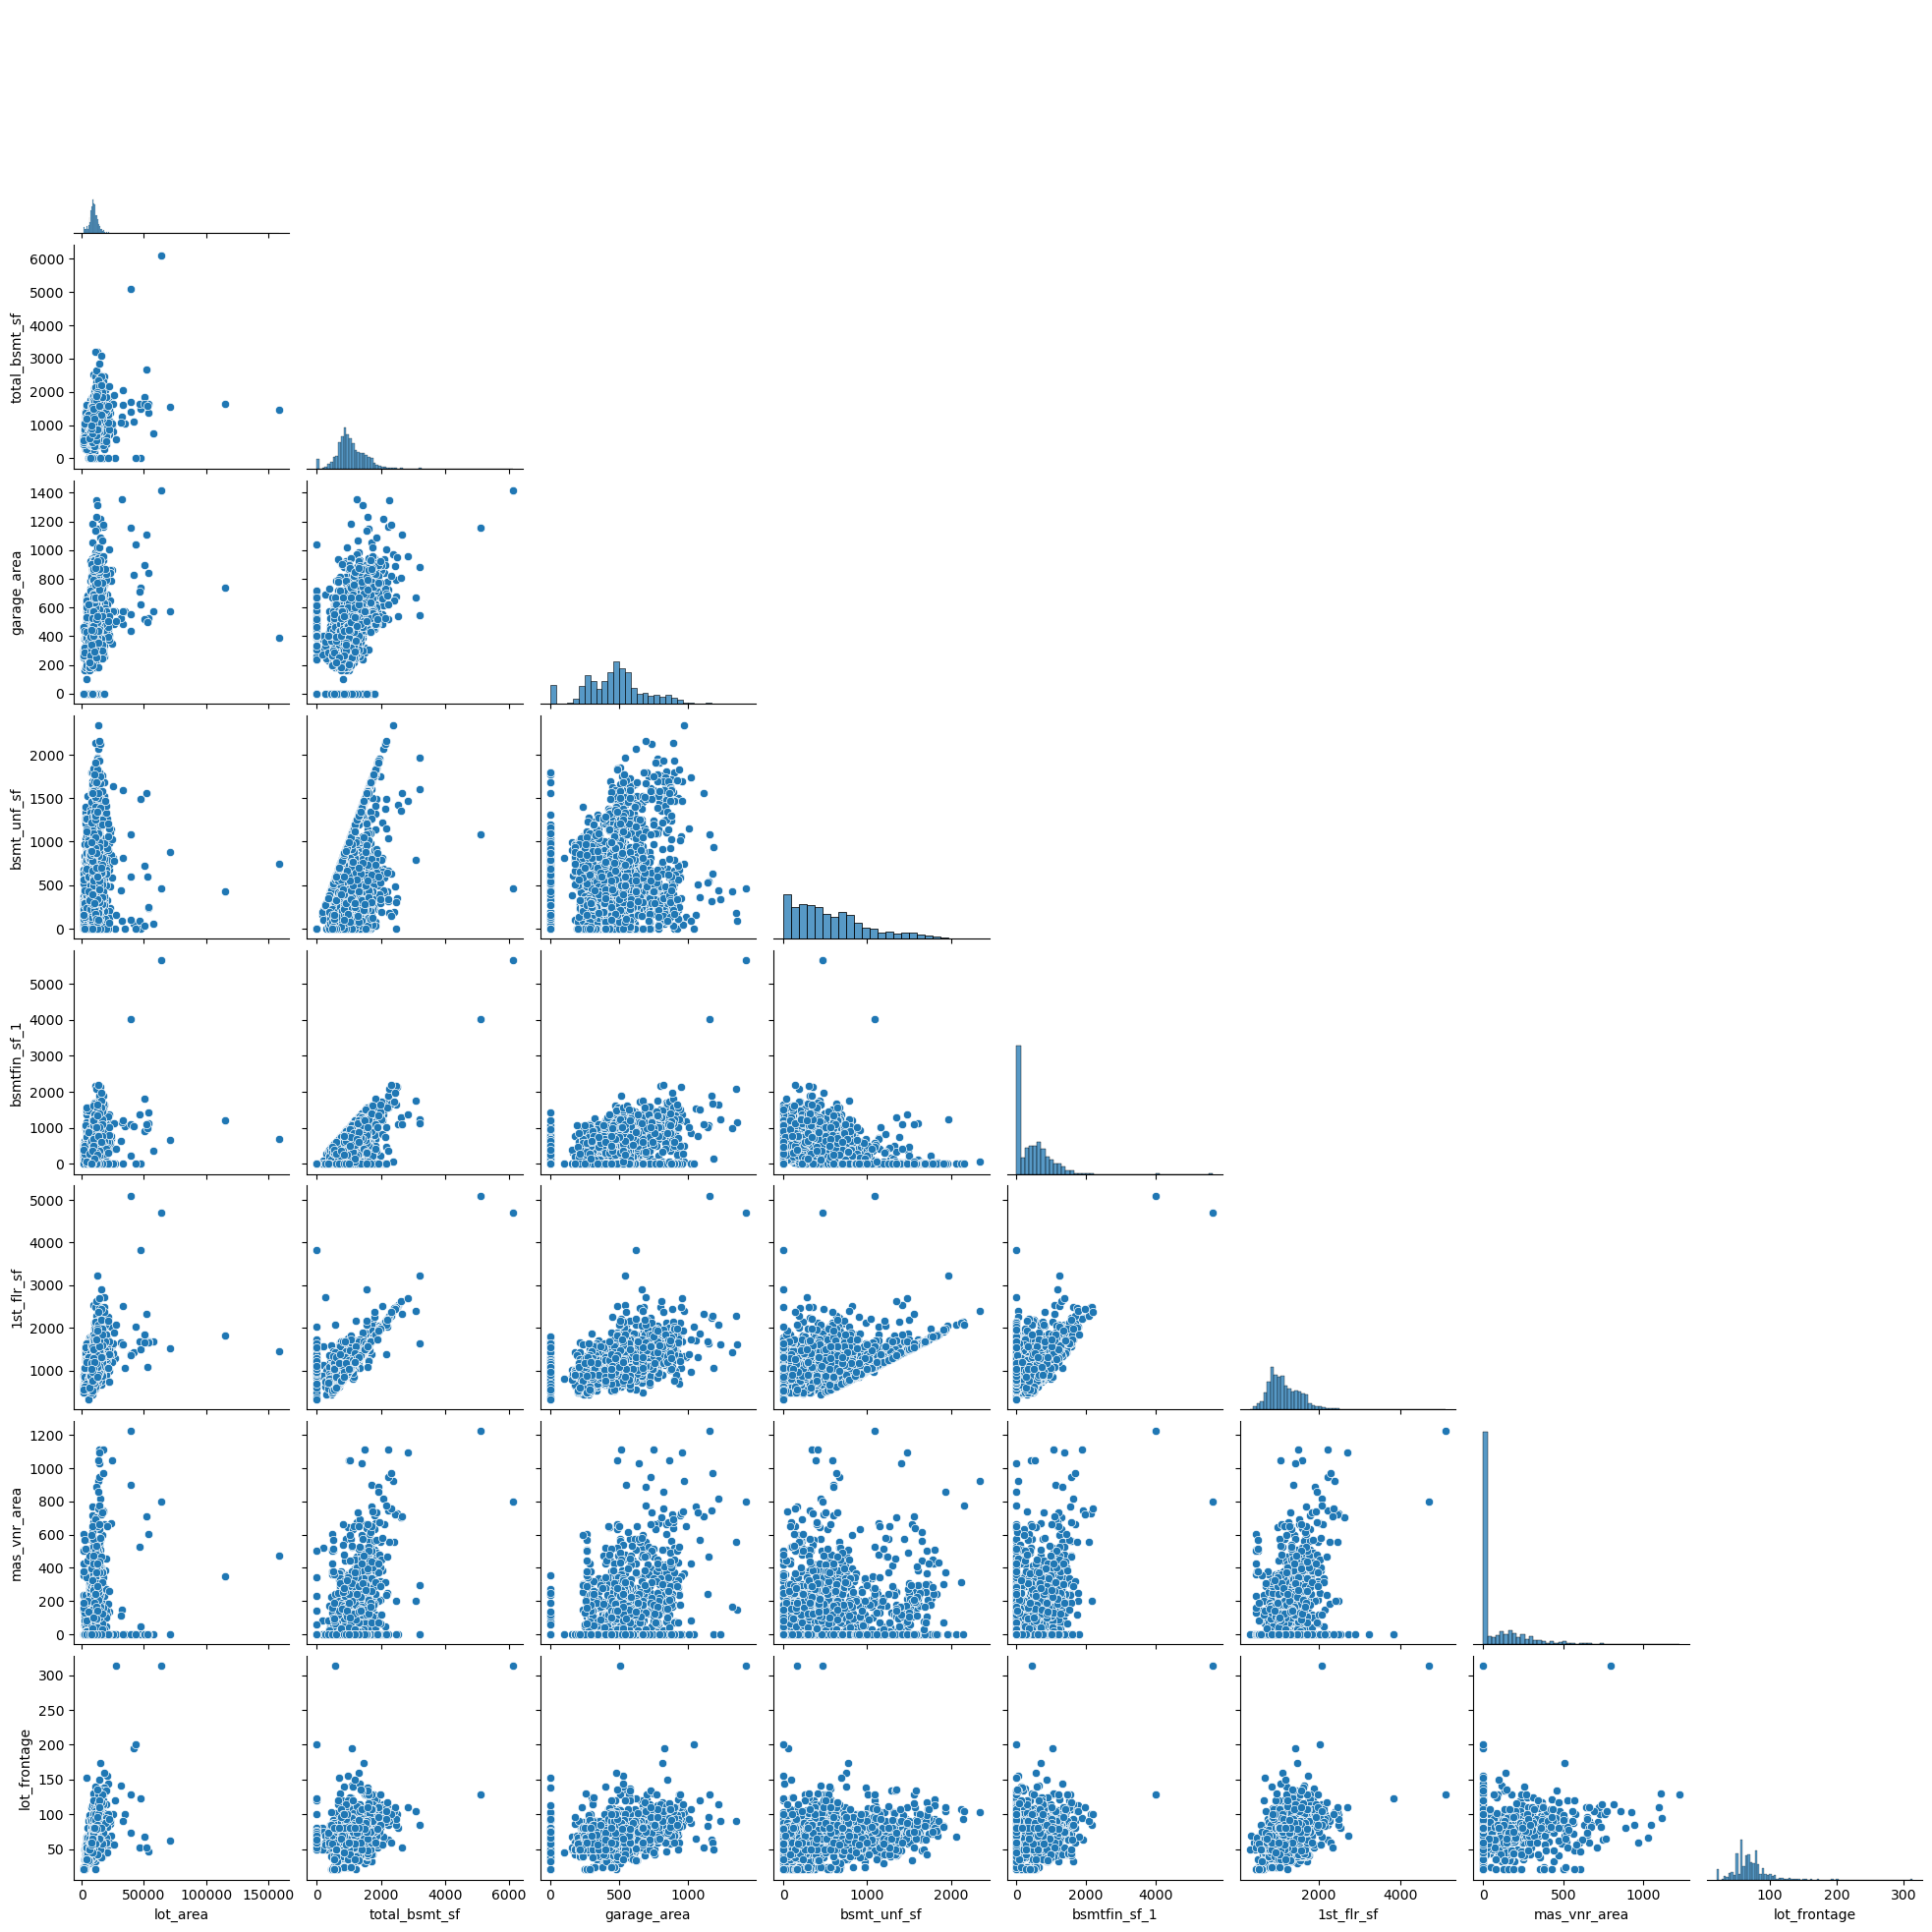

In [97]:
#gain confidence over the linearity assumption which is a prerequisite for PCA.
sns.pairplot(df_size[['lot_area', 'total_bsmt_sf', 'garage_area', 'bsmt_unf_sf', 'bsmtfin_sf_1', '1st_flr_sf',
                      'mas_vnr_area', 'lot_frontage']], corner= True)
plt.show()

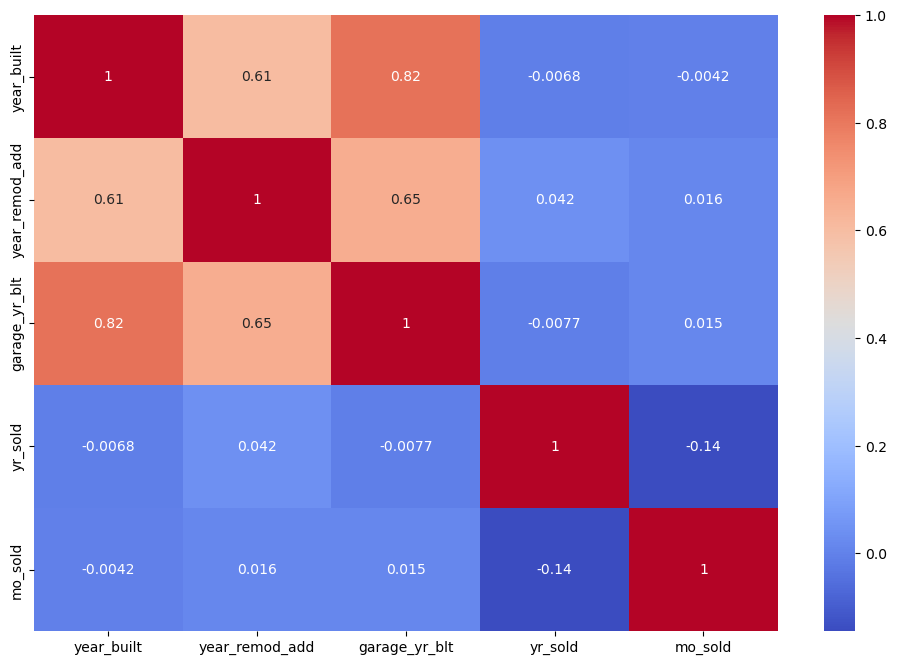

In [62]:
# Create the heatmap
plt.figure(figsize=(12,8)) # Set the figure size
sns.heatmap(df_age_vars.corr(), annot=True, cmap='coolwarm') # Create a heatmap with correlations
plt.show()

In [87]:
# Assume `df` is your DataFrame
corr_matrix = df_age_vars.corr()

# Get pairs of variables with correlation greater than 0.4 and less than 1
pairs_to_drop = set()
cols = df_age_vars.columns
for i in range(0, corr_matrix.shape[1]):
    for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))

strong_pairs = []
for pair in pairs_to_drop:
    if 0.3 < corr_matrix.loc[pair[0], pair[1]] < 1:
        strong_pairs.append(pair)

print(strong_pairs)

[('garage_yr_blt', 'year_remod_add'), ('garage_yr_blt', 'year_built'), ('year_remod_add', 'year_built')]


In [88]:
pairs = [('garage_yr_blt', 'year_remod_add'), ('garage_yr_blt', 'year_built'), ('year_remod_add', 'year_built')]

# Flatten the list of pairs and convert to a set to get unique values
unique_columns = set([item for sublist in pairs for item in sublist])

print(unique_columns)

{'garage_yr_blt', 'year_remod_add', 'year_built'}


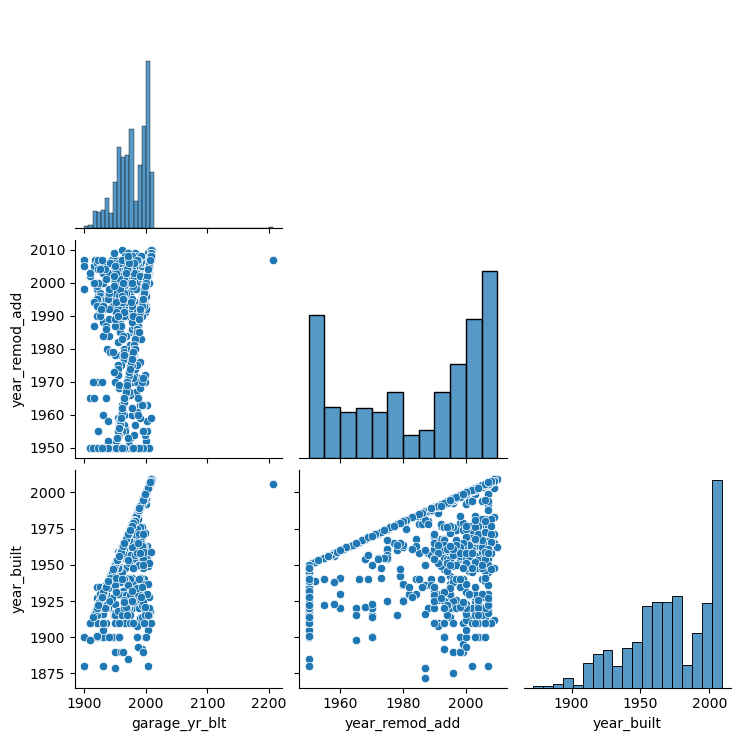

In [90]:
#gain confidence over the linearity assumption which is a prerequisite for PCA.
sns.pairplot(df_age_vars[['garage_yr_blt', 'year_remod_add', 'year_built']], corner= True)
plt.show()

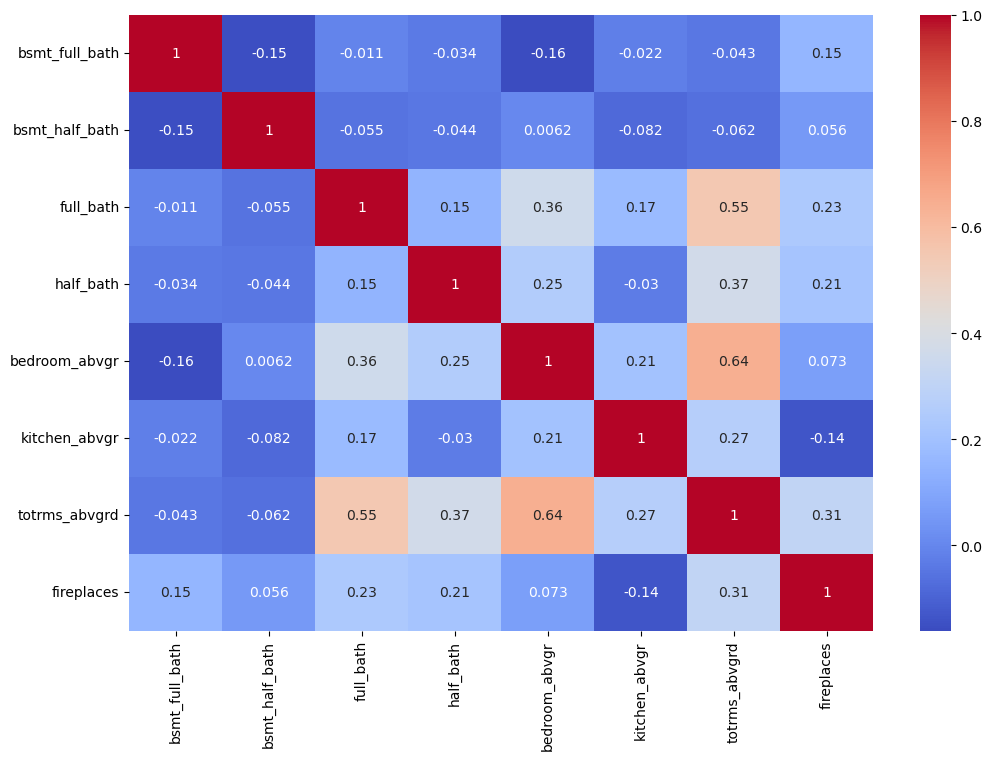

In [65]:
# Create the heatmap
plt.figure(figsize=(12,8)) # Set the figure size
sns.heatmap(df_roommage_vars.corr(), annot=True, cmap='coolwarm') # Create a heatmap with correlations
plt.show()

In [92]:
corr_matrix = df_roommage_vars.corr()

# Get pairs of variables with correlation greater than 0.4 and less than 1
pairs_to_drop = set()
cols = df_roommage_vars.columns
for i in range(0, corr_matrix.shape[1]):
    for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))

strong_pairs = []
for pair in pairs_to_drop:
    if 0.3 < corr_matrix.loc[pair[0], pair[1]] < 1:
        strong_pairs.append(pair)

print(strong_pairs)

[('bedroom_abvgr', 'full_bath'), ('totrms_abvgrd', 'full_bath'), ('totrms_abvgrd', 'bedroom_abvgr'), ('totrms_abvgrd', 'half_bath'), ('fireplaces', 'totrms_abvgrd')]


In [93]:
pairs = [('bedroom_abvgr', 'full_bath'), ('totrms_abvgrd', 'full_bath'), ('totrms_abvgrd', 'bedroom_abvgr'),
         ('totrms_abvgrd', 'half_bath'), ('fireplaces', 'totrms_abvgrd')]

# Flatten the list of pairs and convert to a set to get unique values
unique_columns = set([item for sublist in pairs for item in sublist])

print(unique_columns)

{'fireplaces', 'bedroom_abvgr', 'full_bath', 'half_bath', 'totrms_abvgrd'}


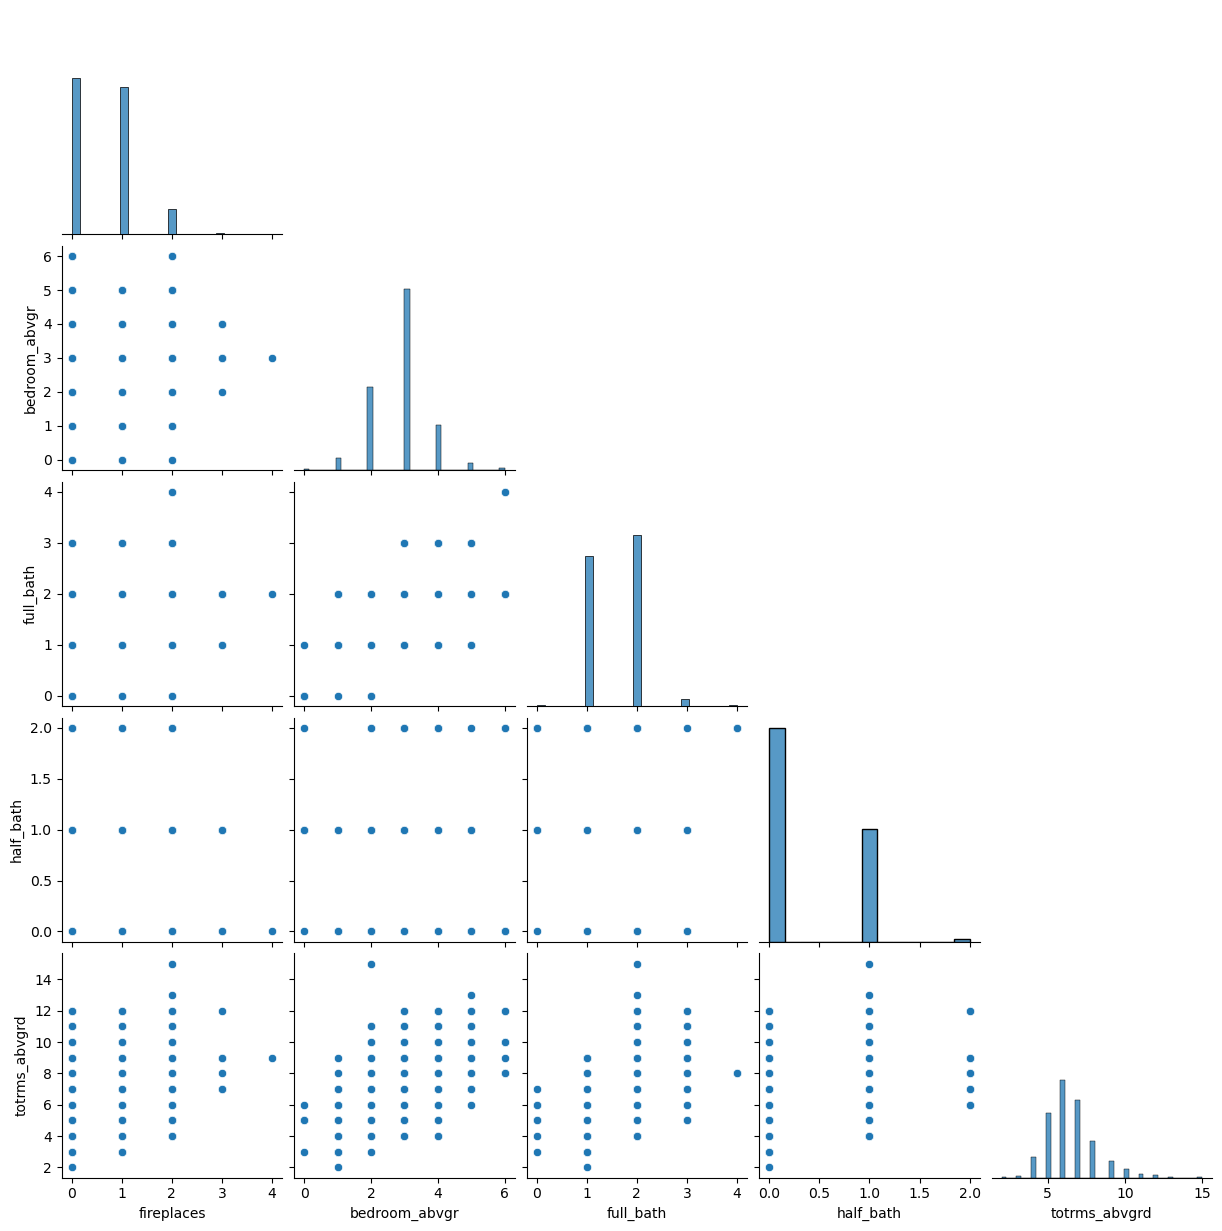

In [95]:
#gain confidence over the linearity assumption which is a prerequisite for PCA.
sns.pairplot(df_roommage_vars[['fireplaces', 'bedroom_abvgr', 'full_bath', 'half_bath', 'totrms_abvgrd']], corner= True)
plt.show()

<font size="8">Imputations and column drops</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


**We are looking here for a large gap in the number of missing values, if a large gap exists, then it will make our imputation threshold obvious. When getting rid of many variables with low single digit null values you run the risk that the indexes of the missing values don't match and that you are removing a large amount of data. We will drop all columns whose missing value perentage exceed the dotted red line.**

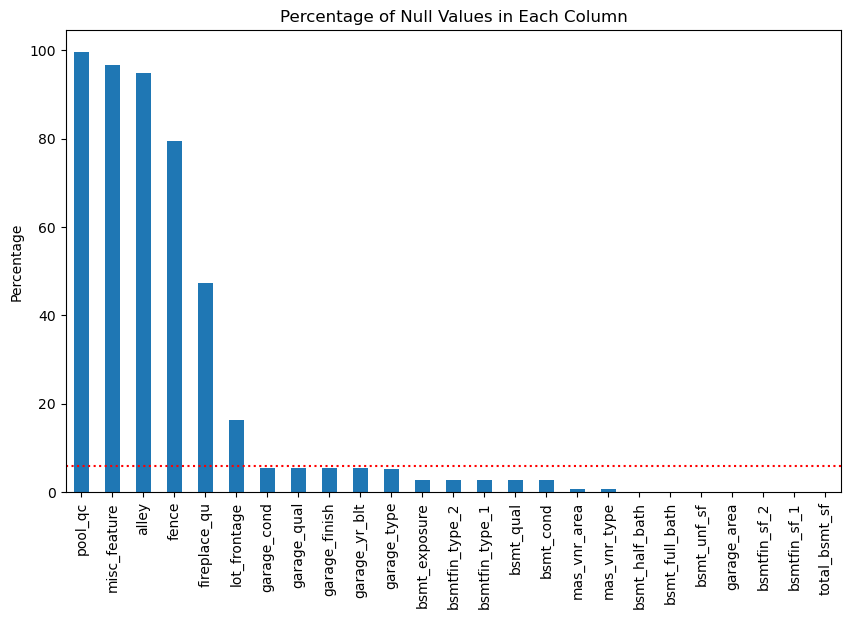

In [16]:
# Calculate the percentage of nulls in each column
null_percent = df.isnull().mean() * 100

# Filter out columns with no nulls
null_percent = null_percent[null_percent > 0]

# Sort in descending order
null_percent = null_percent.sort_values(ascending=False)

# Create bar chart
plt.figure(figsize=(10, 6))
null_percent.plot(kind='bar')
plt.ylabel('Percentage')
plt.title('Percentage of Null Values in Each Column')

# Add a horizontal dotted red line at y=6
plt.axhline(y=6, color='r', linestyle='dotted')

plt.show()

In [20]:
#pick the model
with open('imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)

In [21]:
#drop columns with nulls greater than 5%
df_size.drop(columns=['lot_frontage'])

,id,lot_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,pool_area,mas_vnr_area,screen_porch,3ssn_porch
0,109,13517,533.0,0.0,192.0,725.0,725,754,0,475.0,0,44,0,0,289.0,0,0
1,544,11492,637.0,0.0,276.0,913.0,913,1209,0,559.0,0,74,0,0,132.0,0,0
2,153,7922,731.0,0.0,326.0,1057.0,1057,0,0,246.0,0,52,0,0,0.0,0,0
3,318,9802,0.0,0.0,384.0,384.0,744,700,0,400.0,100,0,0,0,0.0,0,0
4,255,14235,0.0,0.0,676.0,676.0,831,614,0,484.0,0,59,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,11449,1011.0,0.0,873.0,1884.0,1728,0,0,520.0,0,276,0,0,0.0,0,0
2047,785,12342,262.0,0.0,599.0,861.0,861,0,0,539.0,158,0,0,0,0.0,0,0
2048,916,7558,0.0,0.0,896.0,896.0,1172,741,0,342.0,0,0,0,0,0.0,0,0
2049,639,10400,155.0,750.0,295.0,1200.0,1200,0,0,294.0,0,189,140,0,0.0,0,0


In [22]:
#drop columns with nulls greater than 5%
df_quality_of_house_vars.drop(columns=['fireplace_qu', 'fence'])

,id,overall_qual,overall_cond,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmtfin_type_1,bsmtfin_type_2,kitchen_qual,functional,garage_qual,garage_finish,garage_cond,pool_qc
0,109,6,8,Gd,TA,TA,TA,GLQ,Unf,Gd,Typ,TA,RFn,TA,NaN
1,544,7,5,Gd,TA,Gd,TA,GLQ,Unf,Gd,Typ,TA,RFn,TA,NaN
2,153,5,7,TA,Gd,TA,TA,GLQ,Unf,Gd,Typ,TA,Unf,TA,NaN
3,318,5,5,TA,TA,Gd,TA,Unf,Unf,TA,Typ,TA,Fin,TA,NaN
4,255,6,8,TA,TA,Fa,Gd,Unf,Unf,TA,Typ,TA,Unf,TA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,8,5,Gd,TA,Gd,TA,GLQ,Unf,Gd,Typ,TA,Fin,TA,NaN
2047,785,4,5,TA,TA,TA,TA,BLQ,Unf,TA,Typ,TA,Unf,TA,NaN
2048,916,6,6,TA,TA,TA,TA,Unf,Unf,TA,Typ,Fa,Unf,Fa,NaN
2049,639,4,5,TA,TA,TA,TA,Rec,LwQ,TA,Typ,TA,Unf,TA,NaN


In [23]:
#drop columns with nulls greater than 5%
df_environment_vars.drop(columns=['alley'])

,id,street,neighborhood
0,109,Pave,Sawyer
1,544,Pave,SawyerW
2,153,Pave,NAmes
3,318,Pave,Timber
4,255,Pave,SawyerW
...,...,...,...
2046,1587,Pave,Timber
2047,785,Pave,Edwards
2048,916,Pave,Crawfor
2049,639,Pave,NAmes


In [19]:
# #The globals() function is used to access the dataframe by its string name 
# #Remember to execute this code in the environment where dfs are avaailable

# #Define the parameter grid for the RandomForestRegressor
# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# # Initialize Random Forest Regressor
# rf = RandomForestRegressor()

# # Initialize GridSearchCV with the RandomForestRegressor and the parameter grid
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)

# # Initialize Iterative Imputer with the GridSearchCV as the estimator
# imputer = IterativeImputer(estimator=grid_search, max_iter=10, random_state=42)

# # Define a dictionary with dataframes and corresponding columns to impute
# df_dict = {
#     'df_size': ['bsmtfin_sf_1','bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'garage_area','mas_vnr_area'],
#     'df_roommage_vars': ['bsmt_full_bath', 'bsmt_half_bath'],
#     'df_age_vars': ['garage_yr_blt'],
#     'df_categories_of_house_vars': ['mas_vnr_type','garage_type','bsmt_exposure'],
#     'df_quality_of_house_vars': ['garage_cond','garage_qual','garage_finish','bsmtfin_type_2','bsmt_cond','bsmt_qual','bsmtfin_type_1']
# }

# # Loop over the dictionary and perform imputation for each dataframe
# for df_name, cols_to_impute in df_dict.items():
#     globals()[df_name][cols_to_impute] = imputer.fit_transform(globals()[df_name][cols_to_impute])


NameError: name 'SequentialFeatureSelector' is not defined

<font size="8">Scaling and One Hot Encoding</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


In [52]:
print("Data types for df_size:")
print(df_size.dtypes)

print("\nData types for df_roommage_vars:")
print(df_roommage_vars.dtypes)

print("\nData types for df_age_vars:")
print(df_age_vars.dtypes)


print("\nData types for df_quality_of_house_vars:")
print(df_quality_of_house_vars.dtypes)

print("\nData types for df_environment_vars:")
print(df_environment_vars.dtypes)


print("\nData types for df_categories_of_house_vars:")
print(df_categories_of_house_vars.dtypes)

Data types for df_size:
id                   int64
lot_frontage       float64
lot_area             int64
bsmtfin_sf_1       float64
bsmtfin_sf_2       float64
bsmt_unf_sf        float64
total_bsmt_sf      float64
1st_flr_sf           int64
2nd_flr_sf           int64
low_qual_fin_sf      int64
garage_area        float64
wood_deck_sf         int64
open_porch_sf        int64
enclosed_porch       int64
pool_area            int64
mas_vnr_area       float64
screen_porch         int64
3ssn_porch           int64
dtype: object

Data types for df_roommage_vars:
id                  int64
bsmt_full_bath    float64
bsmt_half_bath    float64
full_bath           int64
half_bath           int64
bedroom_abvgr       int64
kitchen_abvgr       int64
totrms_abvgrd       int64
fireplaces          int64
dtype: object

Data types for df_age_vars:
id                  int64
year_built          int64
year_remod_add      int64
garage_yr_blt     float64
yr_sold             int64
mo_sold             int64
dtype: ob

The bar graph below is to confirm the number of unique categories in each column. Predictor variables with large number of categories will increase the dimensionality of our data. With 39 columns contained 245 categories within those columns, we will increase our dimensionality by 206 dimensions (245-39) after one hot encoding our categorical vairables.

In [25]:
# Select columns where datatype is 'object'
object_cols = df.select_dtypes(include=['object']).columns

# Initialize a variable to store the total sum
total_sum = 0

# For each object column, print the count of unique categories and add it to the total sum
for col in object_cols:
    num_unique_categories = df[col].nunique()
    total_sum += num_unique_categories

# Print the total sum
print(f'\nTotal Number of Unique Categories Across All Columns: {total_sum}')


Total Number of Unique Categories Across All Columns: 261


The y-axis of the chart below shows the number of categories in each categorical column, showing its contribution to the increase in dimensions stemming from one hot encoding. The color shading of the bar chart are the results of apply the Herfindahl Hirschman Index to the categories of the categorical variable in order to summarize its class imbalance in a single metric. We see deeply imbalanced classes represented by the higher end of the HHI calculation. For context, a single category comprising 100% of observations would have the maximum value of 10,000. Our data has several categories above 8,000. The highly imbalanced classes are probably a result of that category not applying to most of the obsevations (i.e. many of the houses not having an unfinished basement, and therefore having a value of "0" for the category).

Undersampling from the majority class is not a good option to address this issue as the high dimensionality of our data already leaves us with a relatively low obsevation/feature ratio putting our model(s) at risk of overfitting. 

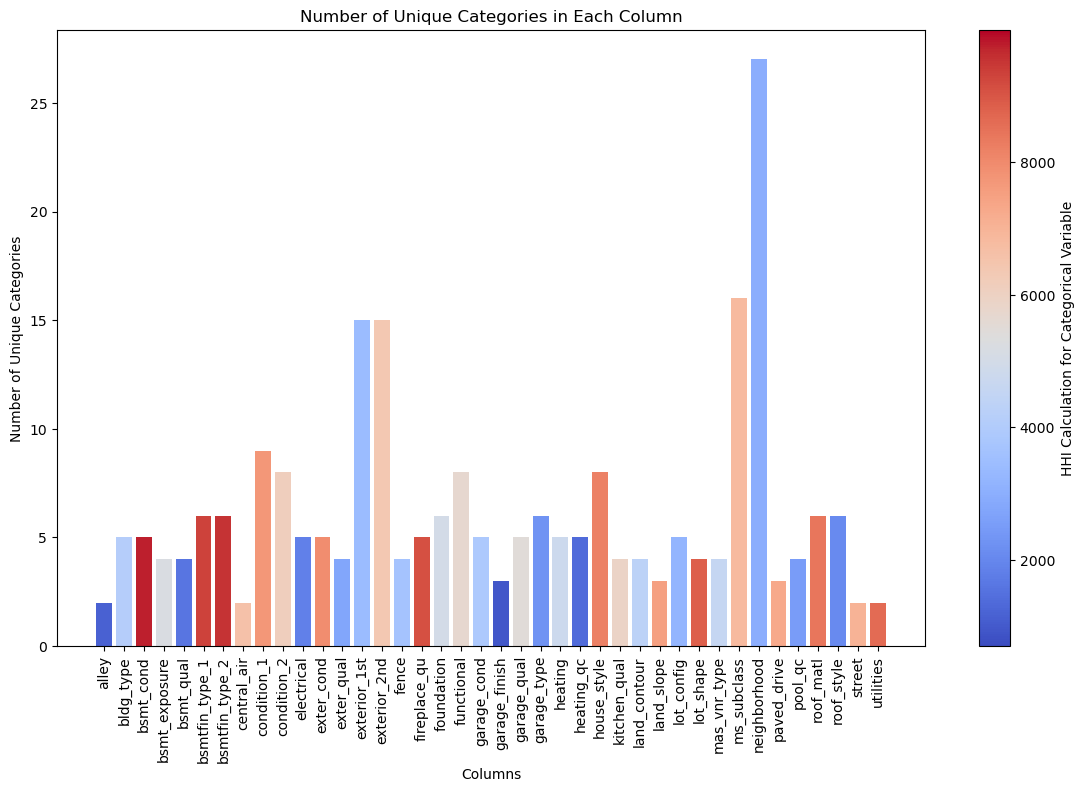

In [26]:
df_ohe_confirmation = pd.concat([df_roommage_vars, df_environment_vars, df_categories_of_house_vars, df_quality_of_house_vars], axis=1)

# Select columns where datatype is 'object'
object_cols = df_ohe_confirmation.select_dtypes(include=['object']).columns

# Initialize a list to store the HHI values
hhi_values = []

# For each object column, calculate the HHI value
for col in object_cols:
    # Get value counts for each category (as percentages)
    value_counts = df_ohe_confirmation[col].value_counts(normalize=True)
    
    # Calculate the HHI value as the sum of the squares of the percentages
    hhi_value = ((value_counts*100)**2).sum()
    
    # Add the HHI value to the list
    hhi_values.append(hhi_value)

# Create a DataFrame for easier plotting
df_hhi = pd.DataFrame({'Column': object_cols, 'HHI': hhi_values, 'NumUnique': [df_ohe_confirmation[col].nunique() for col in object_cols]})

# Create a color palette that maps each HHI value to a color
rank = df_hhi['HHI'].argsort().argsort()  # Rank items in ascending order
palette = sns.color_palette("coolwarm", len(df_hhi))

# Sort the DataFrame by column name for a more intuitive display
df_hhi.sort_values('Column', inplace=True)

# Create the bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(df_hhi['Column'], df_hhi['NumUnique'], color=np.array(palette[::-1])[rank])

# Create a colorbar with a label
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=df_hhi['HHI'].min(), vmax=df_hhi['HHI'].max()))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('HHI Calculation for Categorical Variable')

ax.set_title('Number of Unique Categories in Each Column')
ax.set_xlabel('Columns')
ax.set_ylabel('Number of Unique Categories')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

In [27]:
df_post_imputations = pd.concat([df_size, df_quality_of_house_vars, df_age_vars, df_roommage_vars, df_environment_vars,
                                 df_categories_of_house_vars, df['saleprice-misc_val']], axis=1)


In [43]:
# Get a list of features with HHI > 6000
high_hhi_features = df_hhi[df_hhi['HHI'] > 6000]['Column'].tolist()

print(high_hhi_features)


['alley', 'bldg_type', 'bsmt_cond', 'bsmtfin_type_2', 'central_air', 'condition_1', 'condition_2', 'electrical', 'exter_cond', 'functional', 'garage_cond', 'garage_qual', 'heating', 'land_contour', 'land_slope', 'paved_drive', 'roof_matl', 'roof_style', 'street', 'utilities']


In [45]:
#these f-tests are 

features = ['alley', 'bldg_type', 'bsmt_cond', 'bsmtfin_type_2', 'central_air', 'condition_1', 'condition_2', 'electrical', 'exter_cond', 
            'functional', 'garage_cond', 'garage_qual', 'heating', 'land_contour', 'land_slope', 'paved_drive', 'roof_matl', 'roof_style', 
            'street', 'utilities']

# Initialize an empty list to store the feature names, F-values, and P-values
results = []

for feature in features:
    categories = df[feature].unique()
    samples = [df['saleprice-misc_val'][df[feature] == category] for category in categories]
    fvalue, pvalue = stats.f_oneway(*samples)
    
    # Add the feature name, F-value, and P-value to the results list
    results.append((feature, fvalue, pvalue))

# Sort the results by F-value (from lowest to highest)
results.sort(key=lambda x: x[1])

# Print the sorted results
for feature, fvalue, pvalue in results:
    print(f"For feature {feature}: F-value: {fvalue}, P-value: {pvalue}")


For feature alley: F-value: nan, P-value: nan
For feature bldg_type: F-value: 21.45259083313299, P-value: 2.4947721723153875e-17
For feature bsmt_cond: F-value: nan, P-value: nan
For feature bsmtfin_type_2: F-value: nan, P-value: nan
For feature utilities: F-value: 0.2969370474795094, P-value: 0.5858725709513602
For feature street: F-value: 1.6328201883023594, P-value: 0.2014685374020848
For feature functional: F-value: 4.392038425905231, P-value: 7.560448387890407e-05
For feature roof_matl: F-value: 5.05822330114635, P-value: 0.0001306503216615695
For feature heating: F-value: 5.310007564692686, P-value: 0.0002979014218642022
For feature land_slope: F-value: 6.477918714536371, P-value: 0.001570975405372336
For feature condition_2: F-value: 7.555786319426178, P-value: 5.240209431041083e-09
For feature exter_cond: F-value: 11.53620462295027, P-value: 2.954956825979024e-09
For feature condition_1: F-value: 11.86903775901052, P-value: 1.2505062798036954e-16
For feature electrical: F-value

In [48]:
features = ['overall_qual', 'overall_cond', 'exter_qual','exter_cond','bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'bsmtfin_type_2', 
            'kitchen_qual', 'functional', 'fireplace_qu','garage_qual', 'garage_finish', 
            'garage_cond', 'fence', 'pool_qc', 'street','alley','neighborhood', 'roof_style','roof_matl','exterior_1st',
            'exterior_2nd','mas_vnr_type', 'foundation','bsmt_exposure','heating','heating_qc',
            'central_air','electrical','garage_type','paved_drive', 'ms_subclass',
            'bldg_type','lot_shape','land_contour','utilities', 'lot_config','land_slope','condition_1','condition_2','house_style']

# Initialize an empty list to store the feature names, F-values, and P-values
results = []

for feature in features:
    categories = df[feature].unique()
    samples = [df['saleprice-misc_val'][df[feature] == category] for category in categories]
    fvalue, pvalue = stats.f_oneway(*samples)
    
    # Add the feature name, F-value, and P-value to the results list
    results.append((feature, fvalue, pvalue))

# Sort the results by F-value (from lowest to highest)
results.sort(key=lambda x: x[1])

# Print the sorted results
for feature, fvalue, pvalue in results:
    print(f"For feature {feature}: F-value: {fvalue}, P-value: {pvalue}")


For feature exter_cond: F-value: 11.53620462295027, P-value: 2.954956825979024e-09
For feature overall_cond: F-value: 43.57980883578388, P-value: 1.6400578333771888e-64
For feature overall_qual: F-value: 502.61496978444666, P-value: 0.0
For feature exter_qual: F-value: 718.9303219222116, P-value: 9.04597107825e-313
For feature bsmt_qual: F-value: nan, P-value: nan
For feature bsmt_cond: F-value: nan, P-value: nan
For feature bsmtfin_type_1: F-value: nan, P-value: nan
For feature bsmtfin_type_2: F-value: nan, P-value: nan
For feature utilities: F-value: 0.2969370474795094, P-value: 0.5858725709513602
For feature street: F-value: 1.6328201883023594, P-value: 0.2014685374020848
For feature functional: F-value: 4.392038425905231, P-value: 7.560448387890407e-05
For feature roof_matl: F-value: 5.05822330114635, P-value: 0.0001306503216615695
For feature heating: F-value: 5.310007564692686, P-value: 0.0002979014218642022
For feature land_slope: F-value: 6.477918714536371, P-value: 0.001570975

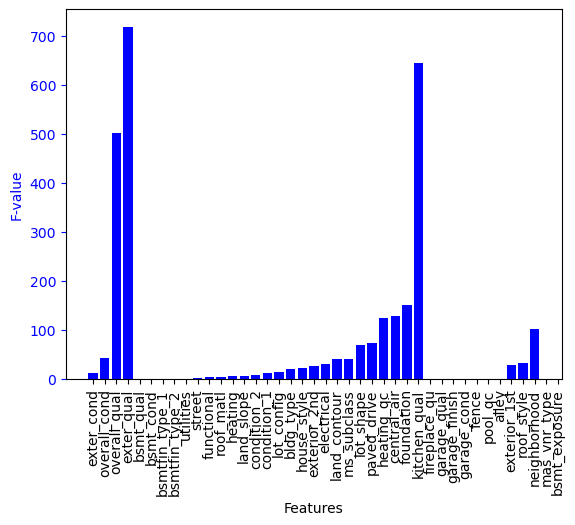

In [50]:
# Separate the results into separate lists
features, fvalues, pvalues = zip(*results)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Create a bar plot for the F-values
ax1.bar(features, fvalues, color='b')
ax1.set_xlabel('Features')
ax1.set_ylabel('F-value', color='b')
ax1.tick_params('y', colors='b')


# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()


<font size="8">Stepwise Regression</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


In [100]:
X = df_size
y = df["saleprice"]

# Define the method (Linear Regression in this case)
lr = LinearRegression()

# Define SequentialFeatureSelector for forward selection
sfs = SequentialFeatureSelector(lr, n_features_to_select=5, direction='forward')

# Fit the model
sfs.fit(X, y)

# Get the selected features
selected_features = X.columns[sfs.get_support()]

print("Selected features: ", selected_features)

NameError: name 'SequentialFeatureSelector' is not defined

<font size="8">Split data into train and verification</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


Ensure that the minority classes are split between the train and verification test sets according to the same proportion of total obesrvations that were assigned to the test and verification datasets. 
In an 80-20 split, 20% of hte minority class will be assigend to the verificaiton dataset.

In [28]:
X = df_post_imputations.drop('saleprice-misc_val', axis=1)
y = df_post_imputations['saleprice-misc_val']

# Specify the columns to stratify on
stratify_cols = ['col1', 'col2', 'col3']  # replace with your column names

# Create a new column for stratification
X['stratify_col'] = X[stratify_cols].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['stratify_col'], random_state=42)

# Remove the stratification column from train and test sets
X_train = X_train.drop('stratify_col', axis=1)
X_test = X_test.drop('stratify_col', axis=1)

KeyError: "None of [Index(['col1', 'col2', 'col3'], dtype='object')] are in the [columns]"

<font size="8">(standard?) scaling and then winsorize</font>
<a id='destination_cell_2'></a>

**noramalize before winsorize or pca** <br>
**scale only the numberic columns** <br>
[Return to Table of Contents](#destination_cell_10)


In [ ]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ss = StandardScaler()
        
    def fit(self, X, y=None):
        X = self.ss.fit_transform(X)
        return self

    def transform(self, X):
        X = self.ss.transform(X)
        X = mstats.winsorize(X, limits=[0.05, 0.05]) # adjust limits if necessary
        return X

# usage:
# ct = ColumnTransformer(transformers=[('transformer', CustomTransformer(), ['column_to_transform'])])


<font size="8">winsorize</font>
<a id='destination_cell_2'></a>

**winsorize only the numeric columns** <br>
[Return to Table of Contents](#destination_cell_10)


In [ ]:
# Assuming df is your DataFrame
df_size = df[['saleprice', 'misc_val', 'lot_frontage', 'lot_area', 'bsmtfin_sf_2', 'bsmt_unf_sf', 
              'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'garage_area', 'wood_deck_sf',
              'open_porch_sf', 'enclosed_porch', 'pool_area', 'screen_porch', '3ssn_porch']].copy()

# Apply the winsorize function to each column
for col in df_size.columns:
    df_size[col] = winsorize(df_size[col], limits=[0.05, 0.05])



Some square footage variables that have high correlations and therefore violate regression's no multicollinearity requirement. In particular we see a correlation of .81 between the squre footage of the basement and the first floor. We also see a .57 correlation between lot area and lot frontage. Instead of removing one of hte highly correlated vairables, we will perform PCA on all of the square footage variables

<font size="8">PCA</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)



**we will use a form of robust scaling that is less sensitive to outliers to perform our pca, we will use the interquartile range to reduce our sensitivity**
**we could use the pairplots to identify individual outliers and then drop them by index**
**we could just normalize using standard deviation, and then winsorize the data by dropping all values above a certain SD**
**winsorize the contiuous features to deal with outliers**



To gain confidence in the linear relationship between a categorical predictor variable and a target variable, you can follow these steps:

Visualize the data: Create box plots or violin plots of the target variable for each category of the predictor variable. If there is a linear relationship, you should see a consistent increase or decrease in the median of the target variable as you move from one category to the next.

Statistical tests: Perform an Analysis of Variance (ANOVA) to test if there are significant differences in the mean of the target variable across the categories. If there are significant differences, it suggests that the categorical variable does have an effect on the target variable.


In [ ]:
#get numeric cols
numeric = [col for col in X_train._get_numeric_data().columns]

#get non-numeric cols 
categories = X_train.select_dtypes(include = 'object').columns

In [ ]:
ohe = OneHotEncoder(drop = 'if_binary',
                   sparse_output = False,
                   handle_unknown = 'ignore')

ctx = ColumnTransformer(
    transformers =[
        ('ohe', ohe, categories),
        ('ss', StandardScaler(), numeric)
    ], remainder = 'passthrough', verbose_feature_names_out=False)

In [ ]:
# Fit the ColumnTransformer to the training data
ctx.fit(X_train)

# Transform the training data
X_train_transformed = ctx.transform(X_train)

# Transform the validation data
X_val_transformed = ctx.transform(X_val)


In [ ]:
# Get the transformed column names
transformed_columns = ctx.get_feature_names_out()

# Create a DataFrame from the transformed data with the column names
df_transformed = pd.DataFrame(X_train_transformed, columns=transformed_columns)




<font size="8">Fitting and evaluate</font> <br>
<a id='destination_cell_6'></a>
[Return to Table of Contents](#destination_cell_10)



In [ ]:
lr = LinearRegression()


In [ ]:
# Combine the ColumnTransformer and LinearRegression model into a pipeline
lr_pipe = Pipeline(steps=[
    ('ctx', ctx),
    ('lr', lr)
])

# Fit the pipeline to the training data
lr_pipe.fit(X_train, y_train)

In [ ]:
# get the coefficients and intercept
coefficients = lr_pipe.named_steps['lr'].coef_
intercept = lr_pipe.named_steps['lr'].intercept_

# print the equation
equation = "y = " + str(intercept)
for i, coef in enumerate(coefficients):
    equation += " + " + str(coef) + " * x" + str(i+1)
print(equation)


In [ ]:
y_pred = lr_pipe.predict(X_val)
residuals=y_pred - y_val
plt.hist(residuals, bins = 20);

In [ ]:
# Looks random

plt.scatter(y_pred, residuals, s = 1)
plt.axhline(0, color = 'orange');

In [ ]:
cross_val_score(lr_pipe, X_train, y_train)


In [ ]:
scores = cross_val_score(lr_pipe, X_train, y_train)
std_dev = np.std(scores)
std_dev

In [ ]:
cross_val_score(lr_pipe, X_train, y_train).mean()


In [ ]:
lr_pipe.score(X_train, y_train)

In [ ]:
lr_pipe.score(X_val, y_val)


In [ ]:
#RMSE
mean_squared_error(y_train, lr_pipe.predict(X_train), squared = False)

In [ ]:
#RMSE
mean_squared_error(y_val, lr_pipe.predict(X_val), squared = False)

<font size="8">Section 7</font>
<a id='destination_cell_7'></a>

[Return to Table of Contents](#destination_cell_10)

In [ ]:
#instantiate it
rg_pipe = Pipeline(
    steps = [
        ('ctx', ctx),
        ('rg', Ridge(alpha = 10))
    ]
)

#fit it!
rg_pipe.fit(X_train, y_train)

In [ ]:
y_pred_rg = rg_pipe.predict(X_val)

In [ ]:
y_pred_rg = rg_pipe.predict(X_val)
residuals_rg=y_pred_rg - y_val
plt.hist(residuals_rg, bins = 20);

In [ ]:
# Looks random

plt.scatter(y_pred_rg, residuals_rg, s = 1)
plt.axhline(0, color = 'green');

In [ ]:
cross_val_score(rg_pipe, X_train, y_train)

In [ ]:
cross_val_score(rg_pipe, X_train, y_train).mean()

In [ ]:
scores_rg = cross_val_score(rg_pipe, X_train, y_train)
std_dev_rg = np.std(scores_rg)
std_dev_rg

In [ ]:
rg_pipe.score(X_train, y_train)

In [ ]:
rg_pipe.score(X_val, y_val)

In [ ]:
#RMSE
mean_squared_error(y_train, rg_pipe.predict(X_train), squared = False)

In [ ]:
#RMSE
mean_squared_error(y_val, rg_pipe.predict(X_val), squared = False)

In [ ]:
lasso_pipe.score(X_train, y_train)

In [ ]:
lasso_pipe.score(X_val, y_val)

In [ ]:
#RMSE
mean_squared_error(y_train, lasso_pipe.predict(X_train), squared = False)

In [ ]:
#RMSE
mean_squared_error(y_val, lasso_pipe.predict(X_val), squared = False)


<font size="8">Section 9</font>
<a id='destination_cell_9'></a>

[Return to Table of Contents](#destination_cell_10)

In [ ]:
#instantiate it
elastic_pipe = Pipeline(
    steps = [
        ('ctx', ctx),
        ('elastic', ElasticNet(alpha=1.0))
    ]
)

#fit it!
elastic_pipe.fit(X_train, y_train)

In [ ]:
y_pred_elastic = elastic_pipe.predict(X_val)


In [ ]:
y_pred_elastic = lasso_pipe.predict(X_val)
residuals_elastic= y_pred_lasso - y_val
plt.hist(residuals_elastic, bins = 20);

In [ ]:
# Looking for randomness!

plt.scatter(y_pred_elastic, residuals_elastic, s = 1)
plt.axhline(0, color = 'purple');

In [ ]:
cross_val_score(elastic_pipe, X_train, y_train)

In [ ]:
scores_elastic = cross_val_score(elastic_pipe, X_train, y_train)
std_dev_elastic = np.std(scores_elastic)
std_dev_elastic

In [ ]:
cross_val_score(elastic_pipe, X_train, y_train).mean()

In [ ]:
elastic_pipe.score(X_train, y_train)

In [ ]:
elastic_pipe.score(X_val, y_val)

In [ ]:
#RMSE
mean_squared_error(y_train, elastic_pipe.predict(X_train), squared = False)

In [ ]:
#RMSE
mean_squared_error(y_val, elastic_pipe.predict(X_val), squared = False)


<font size="8">test residual autocorrelations</font>
<a id='destination_cell_9'></a>

[Return to Table of Contents](#destination_cell_10)


<font size="8">test residual heteroskedasticity</font>
<a id='destination_cell_9'></a>

[Return to Table of Contents](#destination_cell_10)


<font size="8">test residual normality</font>
<a id='destination_cell_9'></a>

[Return to Table of Contents](#destination_cell_10)